# 🧭 Solving the Traveling Salesman Problem on UK Pubs using Gurobi

This notebook guides you through solving the TSP using real-world data: the coordinates of **24,727 UK pubs**.

We use the Gurobi solver with progressively increasing sample sizes (50, 100, 1000, all).

In [1]:
%pip install gurobipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.5/14.5 MB 84.0 MB/s eta 0:00:00


In [25]:
# ✅ Imports
import random
import json
import matplotlib.pyplot as plt
from math import sqrt
from gurobipy import Model, GRB, quicksum


## 📂 Load and sample pub coordinates from `.tsp` file

In [26]:
def load_uk_pubs_tsp(file_path):
    coords = []
    with open(file_path, 'r') as f:
        lines = f.readlines()
        start = False
        for line in lines:
            if line.startswith("NODE_COORD_SECTION"):
                start = True
                continue
            if start:
                if line.strip() == "EOF":
                    break
                parts = line.strip().split()
                if len(parts) == 3:
                    idx, lat, lon = parts
                    coords.append((int(idx), float(lat), float(lon)))
    return coords

In [4]:
def sample_nodes(coords, sample_size, seed=42):
    random.seed(seed)
    return random.sample(coords, sample_size)

def plot_sample(sample, title='Sampled Pubs'):
    lats = [lat for (_, lat, _) in sample]
    lons = [lon for (_, _, lon) in sample]
    plt.figure(figsize=(6, 8))
    plt.scatter(lons, lats, s=10)
    plt.title(title)
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.grid(True)
    plt.show()

## 🎯 Build the Gurobi TSP model

In [27]:
def distance(i, j):
    return sqrt((i[1] - j[1])**2 + (i[2] - j[2])**2)

def build_gurobi_model(sample):
    model = Model()
    n = len(sample)
    ids = [i[0] for i in sample]
    id_to_index = {id_: idx for idx, id_ in enumerate(ids)}

    # x[i,j]: binary decision variable for edge
    x = {}
    for i in range(n):
        for j in range(i+1):
            if i != j:
                x[i, j] = model.addVar(obj=distance(sample[i], sample[j]), vtype=GRB.BINARY, name=f"e_{i}_{j}")
    model.modelSense = GRB.MINIMIZE
    model.update()

    # Degree-2 constraint
    for i in range(n):
        model.addConstr(quicksum(x[max(i,j), min(i,j)] for j in range(n) if i != j) == 2)

    return model, x

## 🧩 Subtour elimination (simple lazy callback)

In [28]:
def subtour(edges, n):
    visited = [False]*n
    cycles = []
    lengths = []
    for i in range(n):
        if not visited[i]:
            current = i
            this_cycle = []
            while not visited[current]:
                visited[current] = True
                this_cycle.append(current)
                for j in range(n):
                    if current != j and (max(current, j), min(current, j)) in edges and j not in this_cycle:
                        current = j
                        break
            cycles.append(this_cycle)
            lengths.append(len(this_cycle))
    return cycles[lengths.index(min(lengths))]

def solve_tsp_with_subtour(sample):
    n = len(sample)
    model, x = build_gurobi_model(sample)
    model.Params.LazyConstraints = 1

    def callback(model, where):
        if where == GRB.Callback.MIPSOL:
            vals = model.cbGetSolution(model._x)
            edges = [(i, j) for (i, j) in model._x if vals[i, j] > 0.5]
            tour = subtour(edges, n)
            if len(tour) < n:
                model.cbLazy(quicksum(model._x[max(i,j), min(i,j)] for i in tour for j in tour if i < j) <= len(tour) - 1)

    model._x = x
    model.optimize(callback)
    return model

## 🚀 Run for a sample (e.g. 50 pubs)

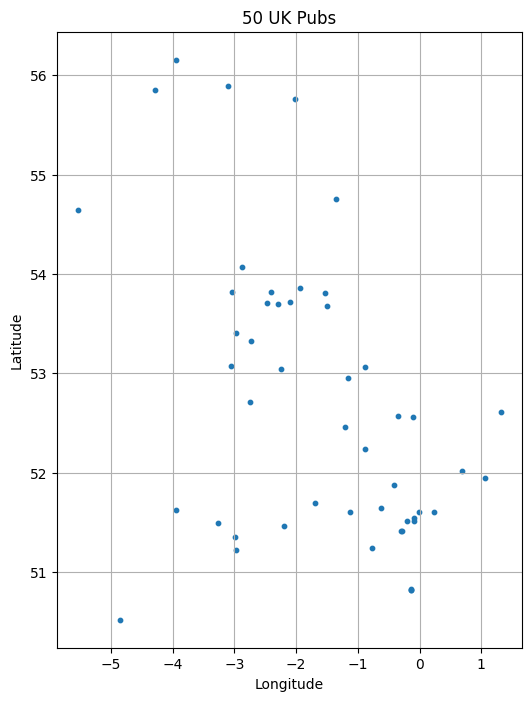

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
LazyConstraints  1

Optimize a model with 50 rows, 1225 columns and 2450 nonzeros
Model fingerprint: 0xec30bbdd
Variable types: 0 continuous, 1225 integer (1225 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e-03, 7e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [2e+00, 2e+00]
Found heuristic solution: objective 115.7816923
Presolve time: 0.01s
Presolved: 50 rows, 1225 columns, 2450 nonzeros
Variable types: 0 continuous, 1225 integer (1225 binary)

Root relaxation: objective 2.678310e+01, 70 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf |

In [29]:
# Load and sample
coords = load_uk_pubs_tsp('uk24727_geom.tsp')  # make sure the file is uploaded or mounted
sample_50 = sample_nodes(coords, 50)
plot_sample(sample_50, '50 UK Pubs')

# Solve TSP
model = solve_tsp_with_subtour(sample_50)

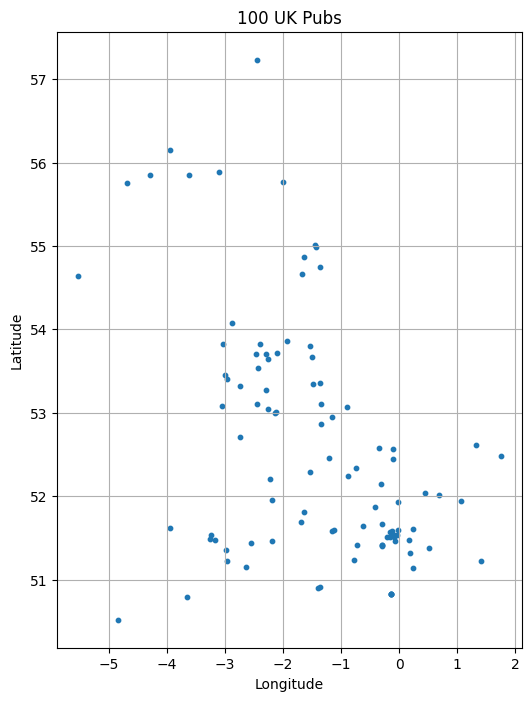

Set parameter LazyConstraints to value 1
Gurobi Optimizer version 12.0.2 build v12.0.2rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Xeon(R) CPU @ 2.20GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 1 physical cores, 2 logical processors, using up to 2 threads

Non-default parameters:
LazyConstraints  1


User-callback calls 9, time in user-callback 0.00 sec


GurobiError: Model too large for size-limited license; visit https://gurobi.com/unrestricted for more information

In [30]:
# Load and sample
coords = load_uk_pubs_tsp('uk24727_geom.tsp')  # make sure the file is uploaded or mounted
sample_100 = sample_nodes(coords, 100) # Changed sample size from 100 to 50
plot_sample(sample_100, '100 UK Pubs') # Changed plot title

# Solve TSP
model = solve_tsp_with_subtour(sample_100)

## 🗺 Visualize the tour using Folium Map

In [32]:
import folium

def show_tsp_tour_on_map(sample, tour):
    coords = [(lat, lon) for _, lat, lon in sample]
    route_coords = [coords[i] for i in tour]
    route_coords.append(route_coords[0])  # return to origin

    avg_lat = sum(lat for lat, lon in route_coords) / len(route_coords)
    avg_lon = sum(lon for lat, lon in route_coords) / len(route_coords)

    fmap = folium.Map(location=[avg_lat, avg_lon], zoom_start=8)
    folium.PolyLine(route_coords, color="blue", weight=3).add_to(fmap)

    for lat, lon in route_coords:
        folium.CircleMarker(location=(lat, lon), radius=2, color='red', fill=True).add_to(fmap)

    return fmap

In [33]:
# After model.solve:
vals = model.getAttr('x', model._x)
selected = [(i, j) for (i, j) in model._x if vals[i, j] > 0.5]
tour = subtour(selected, len(sample_50))
show_tsp_tour_on_map(sample_50, tour)